## Fraud: A how-to guide

[87, 38, 55, 109, 6, 88, 14, 58, 46, 57]


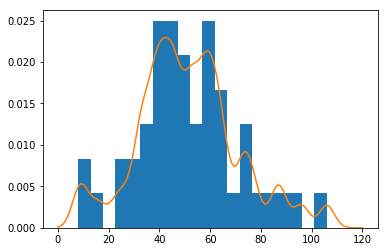

In [39]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.neighbors.kde import KernelDensity

data = pd.read_csv('anonymized.csv')
data['Year_Month'] = [ i[2:] for i in data['Date'] ]

#(1)the number of transactions that occur in a single month.
occurances = data.groupby('Year_Month').count()
plt.hist(occurances['Amount'],bins=16,normed=True)

#fitting it into a gaussian mixture model
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(occurances['Amount'].as_matrix().reshape((-1, 1)))
x_range = np.linspace(0, 120, 120).reshape((-1, 1))
y_density = np.exp(kde.score_samples(x_range))
plt.plot(x_range, y_density, color='C1', label='density')

sample1 = map(int, kde.sample(10)) 
print sample1

[28, 20, 18, 16, 10, 22, 5, 17, 12, 27]


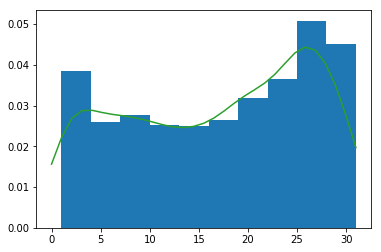

In [97]:
#(2)the day in the month that a transaction will occur on.
data["day_of_month"] = [int(i[0:2]) for i in data['Date']]
day = np.asarray(data["day_of_month"])
occurances_by_day = data.groupby('day_of_month').count()
occurances_by_day_count = occurances_by_day['Amount'].tolist()
plt.hist(day,normed=True)

day = day.reshape(-1, 1)
kde_by_day = KernelDensity(kernel='gaussian', bandwidth=2).fit(day)
x_range = np.linspace(0, 31, 31).reshape((-1, 1))
y_density_by_day = np.exp(kde_by_day.score_samples(x_range))
plt.plot(x_range, y_density_by_day, color='C2', label='density')

sample2 = map(int, kde_by_day.sample(10)) 
print sample2

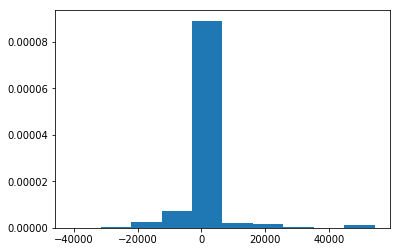

In [110]:
#Transaction size
transize = data['Amount'].values.reshape(-1,1)
plt.hist(transize,normed=True)

kde_transize = KernelDensity(kernel='gaussian', bandwidth=100).fit(transize)
x_range = np.linspace(-40000, 50000, 90000).reshape((-1, 1))
y_density_transize = np.exp(kde_transize.score_samples(x_range))

[[ -911.65649302]
 [ -216.45958764]
 [ -904.75391471]
 [ -266.12769812]
 [-1959.66084716]
 [ -190.7239419 ]
 [ -302.30465154]
 [   72.02389908]
 [   30.23602055]
 [-1126.98331432]]


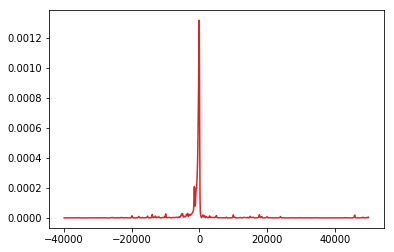

In [108]:
#The probablity density function
plt.plot(x_range, y_density_transize, color='C3', label='density')
sample3 = kde_transize.sample(10)
print sample3

#### Sampling from these density models, create a fictitious month of personal transactions. Explain what flaws still remain in your model that a forensic accountant might be able to find and determine that this was a fraudulent set of transactions.
To model the data of a month, I assume we need to set a fixed month_of_year (let's pick November here) then sample from the data given this set month = 11

(2518, 2)


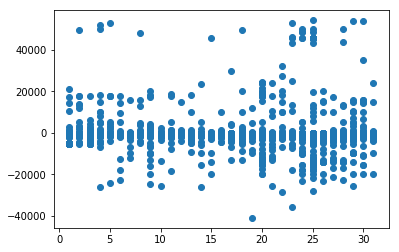

In [165]:
from sklearn.mixture import GaussianMixture

data['datetime'] = pd.to_datetime(data['Date'],errors = 'coerce', format ='%d%b%Y')
data["month_of_year"] = [i.month for i in data['datetime']]
Nov_data = data.ix[data['month_of_year']== 11]
print X.shape
X = data[["Amount","day_of_month"]]
plt.scatter(X["day_of_month"],X["Amount"])

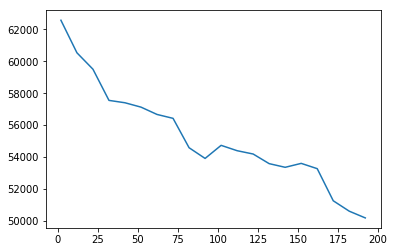

In [217]:
n_components = np.arange(2, 200, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(X).aic(X) for model in models]
plt.plot(n_components, aics)

In [201]:
#From the plot, a choice of 200 components will yield good results and avoid over fitting
#However it's not the global minimum 
n_transaction = map(int, kde.sample(1)) 
print n_transaction #sample the number of transactions for our fake data
gmm = GaussianMixture(200, covariance_type='full', random_state=0).fit(X)
X_fake = gmm.sample(n_transaction[0])#the result is an one-item list

[43]


In [211]:
amount = pd.Series(X_fake[0][:,0],name='AMOUNT')
day_of_month = pd.Series(map(int, X_fake[0][:,1]), name = 'DAY OF MONTH')
fakedata = pd.concat([day_of_month, amount], axis=1)
fakedata = fakedata.round({'AMOUNT': 2})
fakedata = fakedata.sort_values(['DAY OF MONTH'])
print fakedata 

    DAY OF MONTH    AMOUNT
13             1   -681.00
39             2     -7.07
33             2    -53.35
8              2    -48.61
27             3   -116.97
41             4   -190.66
17             5    -35.37
0              6  -1500.00
38             7   -150.80
16             7    -33.69
35             8  -3844.30
42             8   -259.25
9              8  -1500.00
6              8  -6156.00
14             9   -244.81
7             13  -1097.53
15            14   -452.93
34            14  -1491.00
31            14   -636.40
23            14   -200.00
22            15   -693.46
11            15   -797.32
21            17  -1028.99
1             17  20000.00
32            18   -662.10
5             18   -316.70
20            18    -50.73
12            19    -84.85
24            19    -39.76
10            19  -1500.00
37            22  -1000.00
26            22   -126.56
29            22     -9.90
36            23  -1000.00
4             24   -865.44
3             24  48341.34
1

A potential pitfall, especailly when we need to create data of multiple months, the choice of month should be considered in sampling the *number of transations* for this specific month. Ideally it should be a 3-variable gaussian mixture model, but I was having trouble implementing it as I couldn't figure out how to fixed on varible and sample the other two from the mixture model (is that possible?). 